# Digit Recognizer
Ilan Valencius

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn import svm
from sklearn.preprocessing import scale
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential, layers
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical

## Code Parameters

In [2]:
# Set to true to only train one type of each model for easy checking
easy_params = False
# Control keras training parameters (speed and code clarity)
verbose = 0 # Set to 0 to hide
batch_sz = 256
max_epochs = 15 # Lower to increase speed when quickly checking models

## Load Data


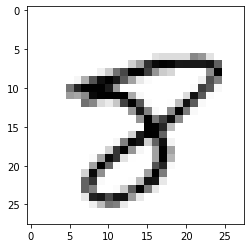

In [3]:
# Load CSV data
x_data = np.genfromtxt('handwritten_digits_images.csv', delimiter=',')
y_data = np.genfromtxt('handwritten_digits_labels.csv', delimiter=',')

# Plot image for quick sanity check
plt.imshow(x_data.reshape(x_data.shape[0], 28, 28)[60000], cmap='Greys')

Create train, validation, test sets

In [4]:
seed = 120

x_train_val, x_test, y_train_val, y_test = train_test_split(x_data,
                                                            y_data,
                                                            test_size=0.2,
                                                            random_state=seed,
                                                            shuffle=True)

x_train, x_val, y_train, y_val = train_test_split(x_train_val,
                                                  y_train_val,
                                                  test_size=0.3,
                                                  random_state=seed, 
                                                  shuffle=True)

# Variables for model parameters
y_classes = len(np.unique(y_data))

Lists to store the best model from each type and its respective validation accuracy

In [5]:
# To compare models
model_type_accs = []
model_type_best = []

# For CNN and MLP
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)
y_test_one_hot = to_categorical(y_test)

# For MLP 
x_train_scale = scale(x_train)
x_val_scale = scale(x_val)
x_test_scale = scale(x_test)

# For CNN
x_train_img = x_train_scale.reshape(x_train_scale.shape[0], 28, 28, 1)
x_val_img = x_val_scale.reshape(x_val_scale.shape[0], 28, 28, 1)
x_test_img = x_test_scale.reshape(x_test_scale.shape[0], 28, 28, 1)

## Model 1 - MLP

In [6]:
def construct_MLP(input_shape, add_layer=False, activation='relu'):
    # Create model
    MLP = Sequential()
    MLP.add(layers.InputLayer(input_shape=input_shape))
    # Intermediate Layers
    if add_layer:
        MLP.add(layers.Dense(32, activation=activation))
    # Output layer (fully-connected):
    MLP.add(layers.Dense(y_classes, activation='softmax'))
    # Compile Model
    MLP.compile(optimizer='adam',
                loss=categorical_crossentropy,
                metrics=['accuracy'])
    return MLP
            

Test MLP Model

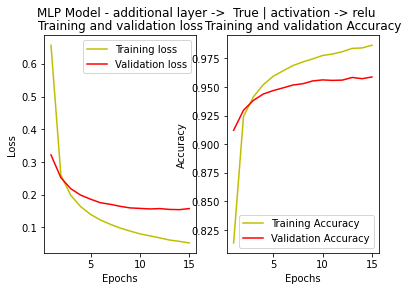

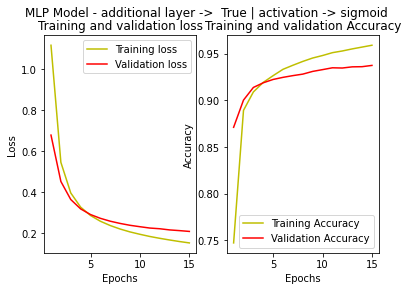

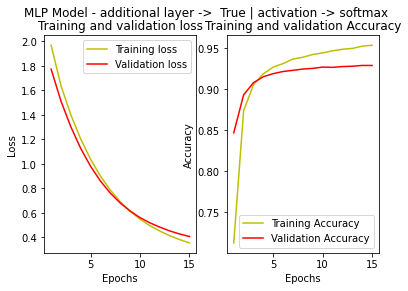

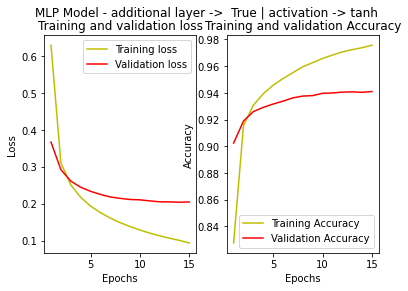

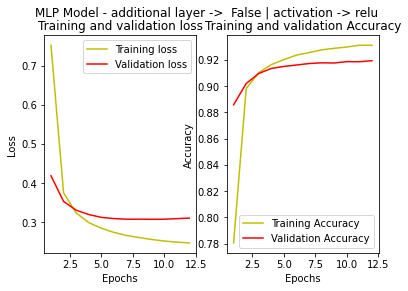

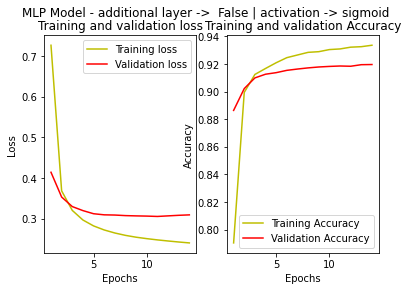

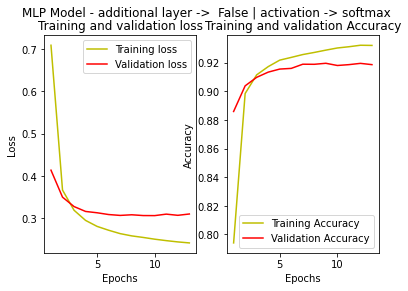

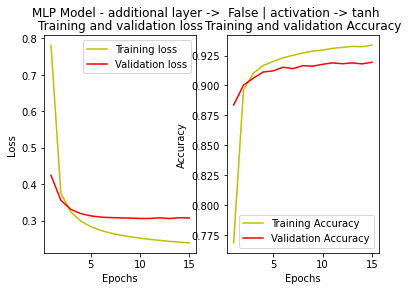

In [7]:
# Set up hyperparameters to test
add_layers = [True, False]
activation = ['relu', 'sigmoid', 'softmax', 'tanh']
MLP_params = list(itertools.product(add_layers, activation))

if easy_params:
    MLP_params = [(True, 'relu')]

MLP_val_accs = []
MLP_models = []

# If you want Val_loss and Val_accuracy plots 
MLP_plotting = True

# Iterate through and test every model
for add_layer, act in MLP_params:
    # print(tf.config.list_physical_devices())
    MLP = construct_MLP(input_shape=784,add_layer=add_layer, activation=act)
    # MLP_test.summary()
    # Early callback stopping to avoid overfitting
    callback = EarlyStopping(monitor='val_loss',
                             patience=3,
                             restore_best_weights=True)
    
    training_history = MLP.fit(x=x_train_scale,y=y_train_one_hot,
                                batch_size=batch_sz,
                                epochs=max_epochs,
                                validation_data=(x_val_scale,y_val_one_hot),
                                use_multiprocessing=True,
                                verbose=verbose,
                                callbacks=[callback])
    MLP_models.append(MLP)
    
    # val_acc = training_history.history['val_accuracy']
    MLP_eval = MLP.evaluate(x=x_val_scale, y=y_val_one_hot, use_multiprocessing=True, verbose=0)
    val_acc = MLP_eval[1]
    MLP_val_accs.append(val_acc)
    
    if MLP_plotting:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('MLP Model - additional layer ->  %s | activation -> %s'%(add_layer, act))
        
        loss = training_history.history['loss']
        val_loss = training_history.history['val_loss']
        acc = training_history.history['accuracy']
        val_acc = training_history.history['val_accuracy']
        
        epochs = range(1, len(loss) + 1)
        ax1.plot(epochs, loss, 'y', label='Training loss')
        ax1.plot(epochs, val_loss, 'r', label='Validation loss')
        ax1.title.set_text('Training and validation loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend(loc='best')
        
        ax2.plot(epochs, acc, 'y', label='Training Accuracy')
        ax2.plot(epochs, val_acc, 'r', label='Validation Accuracy')
        ax2.title.set_text('Training and validation Accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend(loc='best')
 

Determine best MLP model (using validation set)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________

	Activation: softmax
	Number of Layers: 2

Validation Set Evaluation:
	Loss: 0.157795 | Accuracy: 0.958690


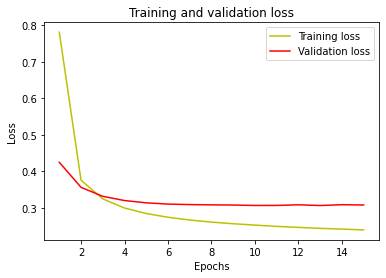

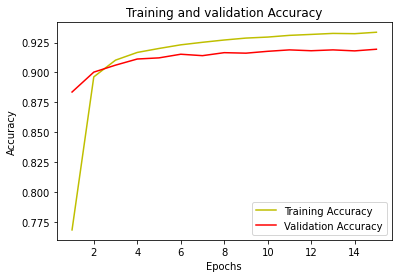

In [8]:
# Evaluate best model via validation accuracy
best_MLP_idx = MLP_val_accs.index(max(MLP_val_accs))
best_MLP = MLP_models[best_MLP_idx]
model_type_best.append(best_MLP)
best_MLP.summary()

activation = best_MLP.layers[1].get_config()['activation']
num_layers = len(best_MLP.layers)

print('\n\tActivation: %s\n\tNumber of Layers: %d'%(activation, num_layers))

# Evaluate on validation accuracy again and plot 
MLP_eval = best_MLP.evaluate(x=x_val_scale, y=y_val_one_hot, use_multiprocessing=True, verbose=0)
MLP_loss = MLP_eval[0]
MLP_acc = MLP_eval[1]

model_type_accs.append(MLP_acc)

print('\nValidation Set Evaluation:')
print('\tLoss: %f | Accuracy: %f'%(MLP_loss, MLP_acc))
# Plot training history (train/validation loss and accuracy values throughout training):
loss = training_history.history['loss']
val_loss = training_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Model 2 - CNN

In [9]:
def construct_CNN(input_shape, additional_layer=False, activation='relu'):
    # Create model
    CNN = Sequential()
    # Intermediate Layers
    CNN.add(layers.Conv2D(28, (3, 3), activation=activation, input_shape=input_shape))
    CNN.add(layers.MaxPooling2D((2, 2)))
    CNN.add(layers.Conv2D(56, (3, 3), activation=activation))
    if additional_layer:
        CNN.add(layers.MaxPooling2D((2, 2)))
        CNN.add(layers.Conv2D(56, (3, 3), activation=activation))
    # Output layer (fully-connected):
    CNN.add(layers.Flatten())
    CNN.add(layers.Dense(y_classes, activation='softmax'))
    # Compile Model
    CNN.compile(optimizer='adam',
                loss=categorical_crossentropy,
                metrics=['accuracy'])
    return CNN

Test CNN Model

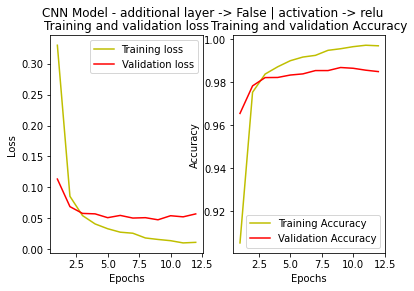

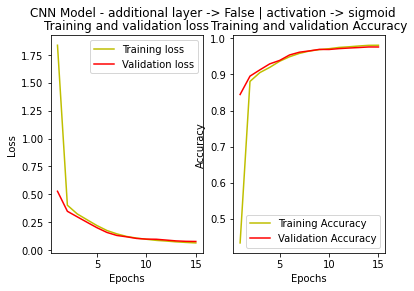

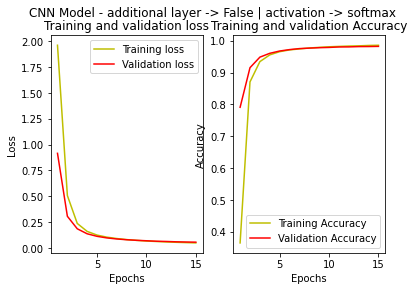

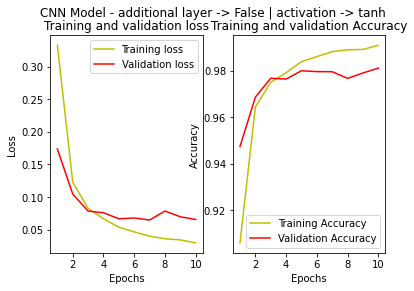

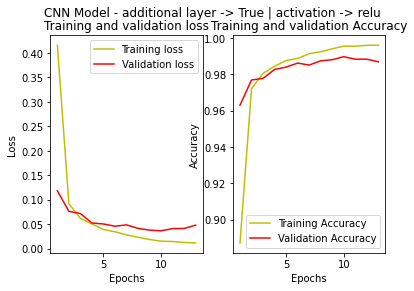

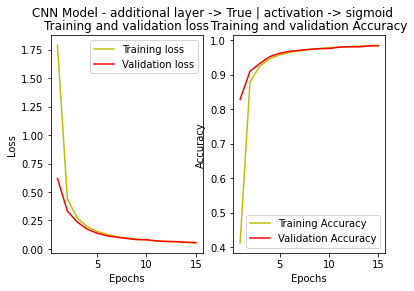

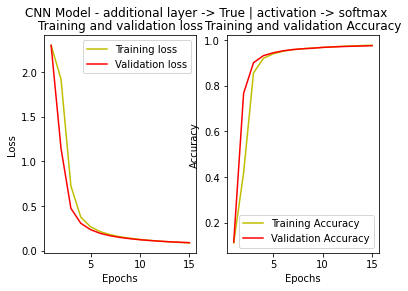

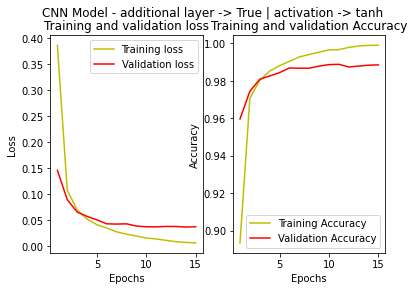

In [10]:
# Set up hyperparameters to test
add_layers = [False, True]
activation = ['relu', 'sigmoid', 'softmax', 'tanh']
CNN_params = list(itertools.product(add_layers, activation))

if easy_params:
    CNN_params = [(True, 'relu')]

CNN_val_accs = []
CNN_models = []
# If you want Val_loss and Val_accuracy plots 
CNN_plotting = True

# Iterate through and test every model
for add_layer, act in CNN_params:
    CNN = construct_CNN(input_shape=(28, 28, 1) ,additional_layer=add_layer, activation=act)
    # CNN.summary()
    # Early callback stopping to avoid overfitting
    callback = EarlyStopping(monitor='val_loss',
                             patience=3,
                             restore_best_weights=True)
    
    training_history = CNN.fit(x=x_train_img,y=y_train_one_hot,
                                batch_size=batch_sz,
                                epochs=max_epochs,
                                validation_data=(x_val_img,y_val_one_hot),
                                use_multiprocessing=True,
                                verbose=verbose,
                                callbacks=[callback])
    CNN_models.append(CNN)
    
    # val_acc = training_history.history['val_accuracy']
    CNN_eval = CNN.evaluate(x=x_val_img, y=y_val_one_hot, use_multiprocessing=True, verbose=0)
    val_acc = CNN_eval[1]
    CNN_val_accs.append(val_acc)
    if CNN_plotting:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('CNN Model - additional layer -> %s | activation -> %s'%(add_layer, act))
        
        loss = training_history.history['loss']
        val_loss = training_history.history['val_loss']
        acc = training_history.history['accuracy']
        val_acc = training_history.history['val_accuracy']
        
        epochs = range(1, len(loss) + 1)
        ax1.plot(epochs, loss, 'y', label='Training loss')
        ax1.plot(epochs, val_loss, 'r', label='Validation loss')
        ax1.title.set_text('Training and validation loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend(loc='best')
        
        ax2.plot(epochs, acc, 'y', label='Training Accuracy')
        ax2.plot(epochs, val_acc, 'r', label='Validation Accuracy')
        ax2.title.set_text('Training and validation Accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend(loc='best')

Determine best CNN Model (using validation set)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 28)        280       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 28)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 56)        14168     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 56)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 3, 56)          28280     
_________________________________________________________________
flatten_4 (Flatten)          (None, 504)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)              

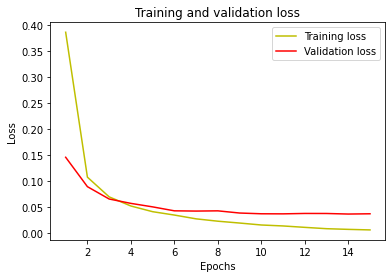

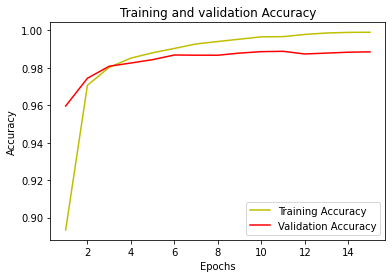

In [11]:
# Evaluate best model via validation accuracy
best_CNN_idx = CNN_val_accs.index(max(CNN_val_accs))
best_CNN = CNN_models[best_CNN_idx]
model_type_best.append(best_CNN)
best_CNN.summary()

activation = best_CNN.layers[0].get_config()['activation']
num_layers = len(best_CNN.layers)

print('\n\tActivation: %s\n\tNumber of Layers: %d'%(activation, num_layers))

# DO I NEED TO DO THIS???
# Evaluate on validation accuracy again and plot 
CNN_eval = best_CNN.evaluate(x=x_val_img, y=y_val_one_hot, use_multiprocessing=True, verbose=0)
CNN_loss = CNN_eval[0]
CNN_acc = CNN_eval[1]

model_type_accs.append(CNN_acc)

print('\nValidation Set Evaluation:')
print('\tLoss: %f | Accuracy: %f'%(CNN_loss, CNN_acc))
# Plot training history (train/validation loss and accuracy values throughout training):
loss = training_history.history['loss']
val_loss = training_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Model 3 - SVC

Test SVC Model

In [12]:
# Set up hyperparameters to test
Cs = [0.25, 0.5, 1]
kernels = ['poly', 'rbf', 'sigmoid'] # Dont use linear because linear is worse rbf
SVC_params = list(itertools.product(Cs, kernels))

if easy_params:
    SVC_params = [(1, 'rbf')]

SVC_val_accs = []
SVC_models = []

verbose=False
# Train and evaluate models
for C, kernel in SVC_params:
    SVC = svm.SVC(C=C, kernel=kernel, verbose=verbose)
    # Fit model
    SVC.fit(x_train, y_train)
    #Evaluate
    SVC_models.append(SVC)
    y_pred = SVC.predict(x_val)
    SVC_val_accs.append(accuracy_score(y_val, y_pred))

Determine best SVC model (using validation set)

In [13]:
# Evaluate best model via validation accuracy
best_SVC_idx = SVC_val_accs.index(max(SVC_val_accs))
best_SVC = SVC_models[best_SVC_idx]
model_type_best.append(best_SVC)

print('\nValidation Set Evaluation:')
print('\tAccuracy: %f'%(max(SVC_val_accs)))
print('\nModel Parameters:')
SVC_params = best_SVC.get_params(deep=False)
print('\tC: %d'%(SVC_params['C']))
print('\tKernel: %s'%(SVC_params['kernel']))


Validation Set Evaluation:
	Accuracy: 0.976131

Model Parameters:
	C: 1
	Kernel: rbf


# Final Model Selection

Determine best model via validation data

In [14]:
best_model_idx = model_type_accs.index(max(model_type_accs))
best_model = model_type_best[best_model_idx]

Evaluate best model performance on test data

In [15]:
if best_model_idx == 2: # SVM model
    print('Model Type -> SVC')
    y_pred = SVC.predict(x_test)
    best_acc = accuracy_score(y_test, y_pred)
    print('\nTest Set Evaluation:')
    print('\tAccuracy: %f'%(best_acc))
    
else: # MLP OR CNN
    if best_model_idx == 0: 
        print('Model Type -> MLP')
        best_eval = best_model.evaluate(x=x_test_scale, y=y_test_one_hot, use_multiprocessing=True, verbose=0)
    else: 
        print('Model Type -> CNN')
        best_eval = best_model.evaluate(x=x_test_img, y=y_test_one_hot, use_multiprocessing=True, verbose=0)
    
    best_model.summary()
    activation = best_model.layers[0].get_config()['activation']
    num_layers = len(best_model.layers)
    print('\n\tActivation: %s\n\tNumber of Layers: %d'%(activation, num_layers))
    
    best_loss = best_eval[0]
    best_acc = best_eval[1]

    print('\nTest Set Evaluation:')
    print('\tLoss: %f | Accuracy: %f'%(best_loss, best_acc))

Model Type -> CNN
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 28)        280       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 28)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 56)        14168     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 56)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 3, 56)          28280     
_________________________________________________________________
flatten_4 (Flatten)          (None, 504)               0         
_________________________________________________________________
dense_16 (Dense)             (None,